# Twitter Sentiment Analysis

## Importing libraries

In [1]:
# File management libraries
import os
import zipfile

# Data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Natural language processessing and text libraries
import nltk
import string
from gensim.utils import simple_preprocess

# Library to split data
from sklearn.model_selection import train_test_split

# Keras libraries for Neural Network development
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers, callbacks

## Downloading and reading the dataset from Kaggle

In [2]:
! pip install kaggle==1.5.6
! kaggle datasets download -d kazanova/sentiment140


  0%|          | 0.00/80.9M [00:00<?, ?B/s]
  1%|          | 1.00M/80.9M [00:00<01:10, 1.19MB/s]
  2%|▏         | 2.00M/80.9M [00:01<00:46, 1.77MB/s]
  4%|▎         | 3.00M/80.9M [00:01<00:37, 2.20MB/s]
  5%|▍         | 4.00M/80.9M [00:01<00:31, 2.60MB/s]
  6%|▌         | 5.00M/80.9M [00:02<00:25, 3.14MB/s]
  7%|▋         | 6.00M/80.9M [00:02<00:22, 3.54MB/s]
  9%|▊         | 7.00M/80.9M [00:02<00:20, 3.86MB/s]
 10%|▉         | 8.00M/80.9M [00:02<00:19, 4.01MB/s]
 11%|█         | 9.00M/80.9M [00:02<00:16, 4.51MB/s]
 12%|█▏        | 10.0M/80.9M [00:03<00:15, 4.78MB/s]
 14%|█▎        | 11.0M/80.9M [00:03<00:14, 5.07MB/s]
 15%|█▍        | 12.0M/80.9M [00:03<00:13, 5.33MB/s]
 16%|█▌        | 13.0M/80.9M [00:03<00:12, 5.50MB/s]
 17%|█▋        | 14.0M/80.9M [00:03<00:12, 5.42MB/s]
 19%|█▊        | 15.0M/80.9M [00:04<00:11, 5.86MB/s]
 20%|█▉        | 16.0M/80.9M [00:04<00:11, 5.96MB/s]
 21%|██        | 17.0M/80.9M [00:04<00:10, 6.22MB/s]
 22%|██▏       | 18.0M/80.9M [00:04<00:10, 6.14MB/s]
 

In [3]:
with zipfile.ZipFile("sentiment140.zip","r") as zip_ref:
    zip_ref.extractall()

df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'Latin-1', names=('target','id','date','flag','user','text'))


In [4]:
os.remove('training.1600000.processed.noemoticon.csv')
os.remove('sentiment140.zip')

In [5]:
df['sentiment'] = (df['target'] == 4)*1
df.head()

,target,id,date,flag,user,text,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0


In [6]:
df.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

## Data Prep

Removing punctuations

In [7]:
def remove_punc(message):
  return ''.join([char for char in message if char not in string.punctuation])

df['text_wo_punctuation'] = df['text'].apply(remove_punc)

Removing stopwords

In [8]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'will', 'aap', 'co', 'day', 'user', 'stock', 'today', 'week', 'year', 'https', 'amp'])
stop_words[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [9]:
def preprocess(text):
  return [word for word in simple_preprocess(text) if word not in stop_words and len(word) >= 3]

In [10]:
df['text_wo_punctuation_and_stopwords'] = df['text_wo_punctuation'].apply(preprocess)
df['text_wo_punctuation_and_stopwords_joined'] = df['text_wo_punctuation_and_stopwords'].apply(lambda x: " ".join(x))

In [11]:
df.head()

,target,id,date,flag,user,text,sentiment,text_wo_punctuation,text_wo_punctuation_and_stopwords,text_wo_punctuation_and_stopwords_joined
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,switchfoot httptwitpiccom2y1zl Awww thats a b...,"[switchfoot, httptwitpiccom, awww, thats, bumm...",switchfoot httptwitpiccom awww thats bummer sh...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0,is upset that he cant update his Facebook by t...,"[upset, cant, update, facebook, texting, might...",upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0,Kenichan I dived many times for the ball Manag...,"[kenichan, dived, many, times, ball, managed, ...",kenichan dived many times ball managed save re...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]",whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0,nationwideclass no its not behaving at all im ...,"[nationwideclass, behaving, mad, cant, see]",nationwideclass behaving mad cant see


## Analysis

### 1. What are the most common words in POSITIVE sentiment tweets?

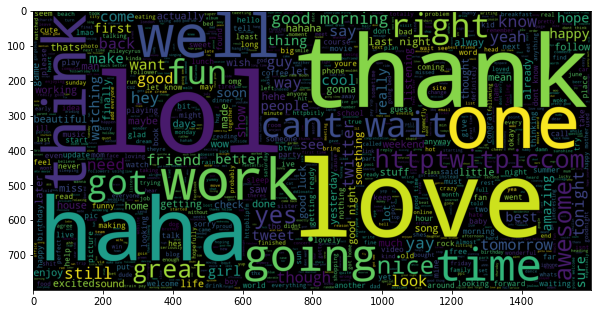

In [12]:
plt.figure(figsize= (10,10))
wc = WordCloud(
    max_words=1000, 
    width=1600,
    height=800
).generate(' '.join(df[df['sentiment'] == 1]['text_wo_punctuation_and_stopwords_joined']))
plt.imshow(wc)

### 2. What are the most common words in NEGATIVE sentiment tweets?

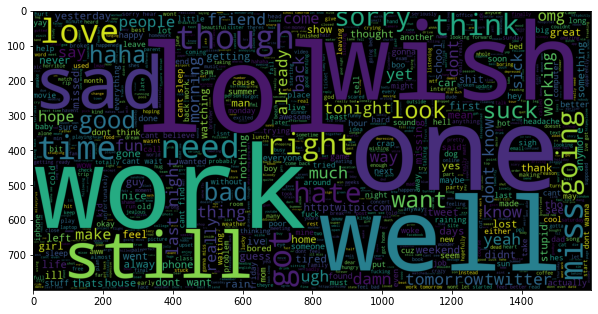

In [13]:
plt.figure(figsize= (10,10))
wc = WordCloud(
    max_words=1000, 
    width=1600,
    height=800
).generate(' '.join(df[df['sentiment'] == 0]['text_wo_punctuation_and_stopwords_joined']))
plt.imshow(wc)

### 3. Does the number of words in a tweet help determine whether it has positive or negative sentiment?

In [14]:
df['num_words'] = df['text_wo_punctuation_and_stopwords'].apply(lambda x : len(x))

<AxesSubplot:xlabel='num_words', ylabel='Count'>

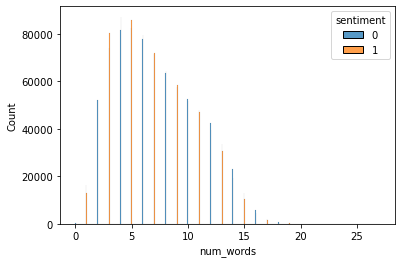

In [15]:
sns.histplot(data=df, x="num_words", hue="sentiment", multiple="dodge")

<AxesSubplot:xlabel='sentiment', ylabel='num_words'>

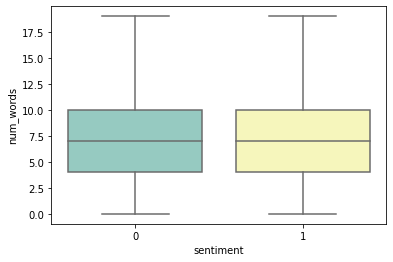

In [16]:
sns.boxplot(data=df, y="num_words", x="sentiment", palette="Set3", showfliers = False)

### 4. Is it possible to predict the sentiment of a new tweet using the existing ones?

#### a) Spliting the data in training, validation and test sets

In [42]:
np.random.seed(42)
reduced_df = df.sample(int(len(df)/160))

In [43]:
X = reduced_df['text_wo_punctuation_and_stopwords']
y = reduced_df['sentiment']

In [44]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size= 0.3, random_state=42)

#### b) Data prep using Keras Tokenizer

In [45]:
list_of_words = []

for tweet in X_train:
    list_of_words += tweet

len(list_of_words)

39771

In [46]:
total_words = len(list(set(list_of_words)))
total_words

12190

In [47]:
tokenizer = text.Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(X_train)

In [48]:
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)

In [49]:
padded_train = sequence.pad_sequences(train_sequences, maxlen = 30)
padded_val = sequence.pad_sequences(val_sequences, maxlen = 30)

In [50]:
X_train[:5]

1247896    [ohhhh, mind, apples, click, chilling, friends...
1529951    [looking, singing, lessons, anyone, knows, any...
679188                  [wow, found, dad, vacation, fathers]
721777     [cats, right, eye, looked, horrible, got, home...
1548607    [andreaswanepoel, hello, sorry, didnt, call, t...
Name: text_wo_punctuation_and_stopwords, dtype: object

In [51]:
train_sequences[:5]

[[1266, 459, 3344, 1046, 1047, 95, 776, 95, 1048, 331, 637, 2088, 902, 210],
 [96, 903, 1568, 211, 708, 211],
 [164, 155, 248, 425, 1267],
 [582, 39, 904, 638, 540, 6, 22, 347, 5, 1268, 1269],
 [3345, 286, 40, 46, 332, 3346, 360, 196, 299, 1049, 3347, 16]]

In [52]:
padded_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 1266,  459, 3344, 1046, 1047,   95,
         776,   95, 1048,  331,  637, 2088,  902,  210],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   96,  903, 1568,  211,  708,  211],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  164,  155,  248,  425, 1267],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  582,   39,  904,
         638,  540,    6,   22,  347,    5, 1268, 1269],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 3345,  286,   40,   46,
         332, 3346,  360,  196, 

In [53]:
y_train_cat = to_categorical(y_train, 2)
y_val_cat = to_categorical(y_val, 2)

In [54]:
y_train[:5].values

array([1, 1, 0, 0, 1], dtype=int32)

In [55]:
y_train_cat[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

#### c) Creating a LSTM Neural Networks

In [56]:
lstm_model = models.Sequential()
lstm_model.add(layers.Embedding(input_dim = total_words, output_dim=512))

lstm_model.add(layers.LSTM(256, kernel_initializer = 'glorot_uniform'))

#lstm_model.add(tf.keras.layers.Dense(128, activation='relu'))
lstm_model.add(layers.Dropout(0.3))
lstm_model.add(layers.Dense(2, activation='softmax', kernel_initializer = 'glorot_uniform'))

lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 512)         6241280   
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7,029,250
Trainable params: 7,029,250
Non-trainable params: 0
_________________________________________________________________


In [57]:
adam = optimizers.Adam(learning_rate=0.0001)
early = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Since we have about the same number of positives and negatives examples we can use accuracy as classification metric to choose the best model. If that wasn't the case, we should use balanced accuracy in order to get a better view for classification of both classes.

In [58]:
y_train.value_counts()

1    2807
0    2793
Name: sentiment, dtype: int64

In [59]:
lstm_model.compile(
    optimizer = adam, 
    loss = 'categorical_crossentropy', 
    metrics = ['acc']
)

Now, let's train our LSTM model

In [60]:
lstm_model.fit(
    padded_train, y_train_cat, 
    epochs=50, 
    batch_size=200, 
    validation_data=(padded_val, y_val_cat),
    callbacks = [early]
)

Epoch 1/50
28/28 [==============================] - 32s 1s/step - loss: 0.6916 - acc: 0.5211 - val_loss: 0.6893 - val_acc: 0.6087
Epoch 2/50
28/28 [==============================] - 44s 2s/step - loss: 0.6832 - acc: 0.6761 - val_loss: 0.6828 - val_acc: 0.6671
Epoch 3/50
28/28 [==============================] - 31s 1s/step - loss: 0.6657 - acc: 0.7611 - val_loss: 0.6669 - val_acc: 0.6875
Epoch 4/50
28/28 [==============================] - 30s 1s/step - loss: 0.6236 - acc: 0.7404 - val_loss: 0.6432 - val_acc: 0.6358
Epoch 5/50
28/28 [==============================] - 30s 1s/step - loss: 0.5367 - acc: 0.8105 - val_loss: 0.6366 - val_acc: 0.6142
Epoch 6/50
28/28 [==============================] - 29s 1s/step - loss: 0.4415 - acc: 0.8416 - val_loss: 0.5946 - val_acc: 0.6992
Epoch 7/50
28/28 [==============================] - 28s 1s/step - loss: 0.3462 - acc: 0.8788 - val_loss: 0.6375 - val_acc: 0.6771
Epoch 8/50
28/28 [==============================] - 28s 1s/step - loss: 0.2710 - acc: 0.90

###